# Example Korteweg de Vries equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [39]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod_torch import DeepMoD
from deepymod_torch.model.func_approx import NN
from deepymod_torch.model.library import Library1D
from deepymod_torch.model.constraint import LeastSquares
from deepymod_torch.model.sparse_estimators import Threshold,PDEFIND
from deepymod_torch.training import train_split_full
from deepymod_torch.training.sparsity_scheduler import TrainTestPeriodic


# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next, we prepare the dataset.

In [3]:
data = np.load('../data/kdv.npy', allow_pickle=True).item()
print('Shape of grid:', data['x'].shape)

Shape of grid: (512, 201)


Let's plot it to get an idea of the data:

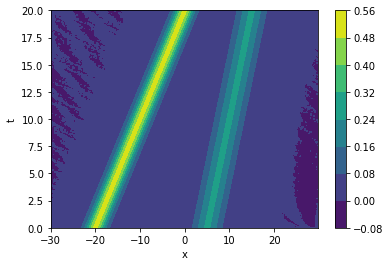

In [4]:
fig, ax = plt.subplots()
im = ax.contourf(data['x'], data['t'], np.real(data['u']))
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)

plt.show()

In [5]:
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))
print(X.shape, y.shape)

(102912, 2) (102912, 1)


As we can see, $X$ has 2 dimensions, $\{x, t\}$, while $y$ has only one, $\{u\}$. Always explicity set the shape (i.e. $N\times 1$, not $N$) or you'll get errors. This dataset is noiseless, so let's add $5\%$ noise:

In [44]:
noise_level = 0.05
y_noisy = y + noise_level * np.std(y) * np.random.randn(y[:,0].size, 1)

The dataset is also much larger than needed, so let's hussle it and pick out a 1000 samples:

In [45]:
number_of_samples = 2000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)

In [46]:
print(X_train.shape, y_train.shape)

torch.Size([2000, 2]) torch.Size([2000, 1])


We now have a dataset which we can use. Let's plot, for a final time, the original dataset, the noisy set and the samples points:

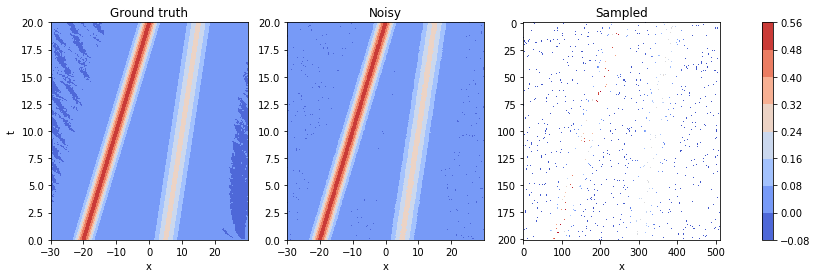

In [47]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

## Configuring DeepMoD

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [48]:
# Configuration of the function approximator: 
network = NN(2, [50, 50, 50,50], 1)
# Configuration of the function approximator: 
library = Library1D(poly_order=1, diff_order=3) 
# Configuration of the sparsity estimator
estimator = Threshold(0.1) 
# Configuration of the constraint function
constraint = LeastSquares() 
# Configuration of the sparsity scheduler
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5) 

Now we instantiate the model:

In [49]:
model = DeepMoD(network, library, estimator, constraint)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 


## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [50]:
train_split_full(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/kdv/', split=0.8, test='full', write_iterations=25, max_iterations=100000, delta=1e-4, patience=8) 

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
      17300     17.30%            6938s   2.77e-05   2.69e-05   7.95e-07   2.90e+00 

KeyboardInterrupt: 

Now that DeepMoD has converged, it has found the following numbers:

In [22]:
model.sparsity_masks

[tensor([False,  True, False, False, False, False, False, False])]

In [26]:
print(model.estimator_coeffs())

[array([[ 0.        ],
       [-0.87954772],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])]
